In [1]:
visual = 10

In [2]:
import os
#os.environ - словарь переменных окружения. Изменяемый (можно добавлять и удалять переменные окружения).
os.environ['DISPLAY']=':1.0'
#MayaVi - это визуализатор научных данных, написанный на Python, который использует VTK и предоставляет графический интерфейс 
from mayavi import mlab
mlab.options.offscreen = True
mlab.init_notebook('x3d')

fcurrent = None
def fc():
    global fcurrent
    fcurrent = mlab.figure(fcurrent)
    return fcurrent
def vrmlview(fname):
    mlab.clf()
    from mayavi.sources.vrml_importer import VRMLImporter
    r = VRMLImporter()
    r.initialize(fname)
    engine = mlab.get_engine()
    f = fc()
    engine.add_source(r)
    f
    return f

Notebook initialized with x3d backend.


In [3]:
import Geant4

from Geant4 import cm, degree, mm, MeV, GeV, TeV, G4ThreeVector

def shift(x=0, y=0, z=0): return G4ThreeVector(x, y, z)

def material(name):
    m = Geant4.G4NistManager.Instance().FindOrBuildMaterial(name)
    assert m is not None
    return m

def particle(name):
    p = Geant4.G4ParticleTable.GetParticleTable().FindParticle(name)
    assert p is not None
    return p


**************************************************************
 Geant4 version Name: geant4-10-06-patch-01    (14-February-2020)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

Visualization Manager instantiating with verbosity "warnings (3)"...


In [4]:
# Geant4.G4NistManager.Instance().ListMaterials("all")

In [5]:
import ROOT
import math

Welcome to JupyROOT 6.18/04


In [6]:
#Class for creating different spheres
class SomeSphere:
    def __init__(self, name, materialName, parent, x, y, z, Rmin, Rmax, phi0, dphi, th0, dth):
        self.name = name
        self.solid = Geant4.G4Sphere(self.name.lower()+"sphere", Rmin, Rmax, phi0, dphi, th0, dth)
        m = material(materialName)
        self.logical = Geant4.G4LogicalVolume( self.solid, m, self.name, None, None, None, True)
        r0 = G4ThreeVector(x, y, z)
        self.physical = Geant4.G4PVPlacement(None, r0, self.logical, self.name, parent, False, 0)
        
class SomeBox:
    def __init__(self, name, materialName, parent, x, y, z, sx, sy, sz):
        self.name = name
        self.solid = Geant4.G4Box(self.name.lower()+"box", 0.5*sx, 0.5*sy, 0.5*sz)
        m = material(materialName)
        self.logical = Geant4.G4LogicalVolume( self.solid, m, self.name, None, None, None, True)
        r0 = G4ThreeVector(x, y, z)
        self.physical = Geant4.G4PVPlacement(None, r0, self.logical, self.name, parent, False, 0)


In [7]:
#Create world
class World(SomeBox):
    def __init__(self, x, y, z, sx, sy, sz):
        super().__init__("World", "G4_Galactic", None, x, y, z, sx, sy, sz)


In [8]:
#Detector

class DetectorConstructor(Geant4.G4VUserDetectorConstruction):
    def __init__(self):
        super().__init__()        
        self.world = World(0, 0, 0, 200*cm, 200*cm, 200*cm)
        self.calorimeter = SomeSphere("Calorimeter", "G4_SODIUM_IODIDE", self.world.logical, 0, 0, 0, 25*cm, 85*cm, 0, 360*degree, 18*degree, (180 - 18*2)*degree)
        
    def Construct(self):
        return self.world.physical
 

In [9]:
#PrimaryGenerator

class PrimaryGenerator(Geant4.G4VUserPrimaryGeneratorAction):
    def __init__(self):
        super().__init__()

        self.particlename = "gamma"
        self.energy = 500*MeV
       
        #create gun
        self.gun = Geant4.G4ParticleGun()

        # set particle type
        self.particle = particle(self.particlename)
        self.gun.SetParticleDefinition(self.particle)
        
        pass

        
    def GeneratePrimaries(self,anEvent):
        #должен поместить сгенерированные частицы в событие
        
        # равномерное распределение по сфере, задаем направление вылета
        tcos0 = math.cos(0*degree)
        tcos1 = math.cos(180*degree)
        tcos = ROOT.gRandom.Uniform(tcos1, tcos0)
        tsin = math.sqrt(1.0 - tcos**2)
        
        phi = ROOT.gRandom.Uniform(0.0, 2.0*math.pi)
        
        direction = Geant4.G4ThreeVector(tsin*math.cos(phi), tsin*math.sin(phi), tcos)
        self.gun.SetParticleMomentumDirection(direction)

        #начальная точка вылета
        position = Geant4.G4ThreeVector(0.0, 0.0, 0.0)
        self.gun.SetParticlePosition(position)
        
        #задаем энергию частицы
        self.gun.SetParticleEnergy(self.energy)
        
        # помещаем частичку в событие
        self.gun.GeneratePrimaryVertex(anEvent)

In [10]:
#Sensitive detector
#Сохраняем энергии, координаты -> гистограммы
class SensitiveDetector(Geant4.G4VSensitiveDetector):
    
    def __init__(self, energy_hist = None, energy_angle_hist = None):
        super().__init__()
        
        self.hit_counter = 0
        
        self.energy_hist = energy_hist
        self.energy_angle_hist = energy_angle_hist
        
        self.energy = 0.0 # in MeV
        
        self.pos = Geant4.G4ThreeVector(0, 0, 0) 
        
        self.ef_energy_counter = 0
    
    def ProcessHits (self, step, rohistory):
        self.hit_counter += 1 #hits in one event
       
        if self.energy_hist is not None:
            deposit = step.GetTotalEnergyDeposit() / MeV
            self.energy += deposit
    
        if self.energy_angle_hist is not None: 
            self.pos += (step.GetPostStepPoint().GetPosition()) * deposit
        
        return True

    #reset parameters before new event
    def reset_memory(self): 
        
        self.energy = 0.0
        self.hit_counter = 0;
        self.pos = self.pos*0

    
    #reset histograms (before new run)
    def reset_hist(self):
        
        self.ef_energy_counter = 0
        
        if self.energy_hist is not None:
            self.energy_hist.Reset()
        if self.energy_angle_hist is not None:
            self.energy_angle_hist.Reset()

    def process(self):
    
        if self.hit_counter > 0:
            
            if (self.energy > 20):
                self.ef_energy_counter += 1
            
            if self.energy_hist is not None:
                self.energy_hist.Fill(self.energy)
            
            if self.energy_angle_hist is not None:
                if self.energy != 0:
                    x = ( self.pos.getX() / cm ) / self.energy
                    y = ( self.pos.getY() / cm ) / self.energy
                    z = ( self.pos.getZ() / cm ) / self.energy
                    pr = z / math.sqrt(x**2 + y**2 + z**2)
                    
                    angle = math.acos(pr) / degree
                    self.energy_angle_hist.Fill(self.energy,angle)

In [11]:
#Сброс памяти детекторов и заполнение их гистограмм
class EventAction(Geant4.G4UserEventAction):

    def __init__(self):
        super().__init__()
        self.detectors = set()
        self.count  = 0

    def BeginOfEventAction(self, event):
        
        if(self.count == 0):
            for a in self.detectors:
                a.reset_hist() 
        
        self.count += 1
                   
        for a in self.detectors:
            a.reset_memory()
        

    def EndOfEventAction(self, event):
        for a in self.detectors:
            a.process()

    def registerDetector(self, a):
        self.detectors.add(a)
        
    def resetDetectorsHist(self,a):
        self.count = 0
        for a in self.detectors:
            a.reset_hist() 
            
    def resetCounter(self):
        self.count = 0

In [12]:
#objects
randEngine = Geant4.Ranlux64Engine()
Geant4.HepRandom.setTheEngine(randEngine)

manager = Geant4.gRunManager

In [13]:
#Physics
PhysicsList = Geant4.FTFP_BERT
physics = PhysicsList()
manager.SetUserInitialization(physics)

<<< Geant4 Physics List simulation engine: FTFP_BERT



In [14]:
#Detector and paricle generator
constructor = DetectorConstructor()
manager.SetUserInitialization(constructor)   

generator = PrimaryGenerator()
manager.SetUserAction(generator)

Event = EventAction()
manager.SetUserAction(Event)

In [15]:
#Hists
detector_energy = ROOT.TH1F("detector_energy", "detector_energy", 150, 440, 520)
energy_angle = ROOT.TH2F("energy_angle", "energy angle histogram", 36, 400, 520, 36, 0, 180)
energy_angle.SetXTitle("Energy")
energy_angle.SetYTitle("Angle")

In [16]:
sdetector = SensitiveDetector(detector_energy, energy_angle)

constructor.calorimeter.logical.SetSensitiveDetector(sdetector)

Event.registerDetector(sdetector)
Event.resetDetectorsHist(sdetector)

In [17]:
manager.Initialize()


 FTFP_BERT : new threshold between BERT and FTFP is over the interval 
 for pions :   3 to 6 GeV
 for kaons :   3 to 6 GeV
 for proton :  3 to 6 GeV
 for neutron : 3 to 6 GeV

### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0


In [18]:
manager.BeamOn(1)


phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

In [19]:
#отрисовка

#Geant4.gApplyUICommand("/run/initialize")
Geant4.gApplyUICommand("/vis/viewer/flush")
Geant4.gApplyUICommand("/vis/open VRML2FILE")
Geant4.gApplyUICommand("/vis/viewer/set/autoRefresh false")
Geant4.gApplyUICommand("/vis/viewer/refresh")
Geant4.gApplyUICommand("/vis/scene/create")
Geant4.gApplyUICommand("/vis/scene/add/volume")
Geant4.gApplyUICommand("/vis/viewer/set/globalLineWidthScale 5")
#Geant4.gApplyUICommand("/vis/geometry/set/colour Calorimeter red")
Geant4.gApplyUICommand("/vis/drawVolume")
#Geant4.gApplyUICommand("/vis/viewer/flush")
Geant4.gApplyUICommand("/vis/viewer/set/viewpointVector -1 -1 0")
Geant4.gApplyUICommand("/vis/viewer/set/lightsVector -1 -1 0")
Geant4.gApplyUICommand("/vis/modeling/trajectories/create/drawByParticleID")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set gamma white")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set proton blue")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set e- yellow")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set e+ green")
Geant4.gApplyUICommand("/vis/sceneHandler/attach")
Geant4.gApplyUICommand("/vis/viewer/set/style wireframe")
Geant4.gApplyUICommand("/vis/set/lineWidth 4")
#Geant4.gApplyUICommand("/vis/viewer/set/viewpointThetaPhi 120. 150.")
Geant4.gApplyUICommand("/vis/viewer/zoom 1.")
Geant4.gApplyUICommand("/tracking/storeTrajectory 1")
Geant4.gApplyUICommand("/vis/scene/add/trajectories")
Geant4.gApplyUICommand("/vis/scene/add/hits")
Geant4.gApplyUICommand("/vis/scene/add/trajectories smooth")
Geant4.gApplyUICommand("/vis/scene/endOfEventAction accumulate")
Geant4.gApplyUICommand("/vis/scene/add/scale")
Geant4.gApplyUICommand("/vis/scene/add/axes")
Geant4.gApplyUICommand("/vis/scene/add/eventID")
Geant4.gApplyUICommand("/vis/scene/add/date")
Geant4.gApplyUICommand("/vis/viewer/set/autoRefresh true")
Geant4.gApplyUICommand("/vis/enable false")
import glob, os
for i in glob.glob("g4*.wrl"):
    print("Remove",i)
    os.unlink(i)

======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             ... truncated/tracking/storeTrajectory 2
Remove g4_00.wrl


In [20]:
Geant4.gApplyUICommand("/vis/enable true")
manager.BeamOn(1)
import glob
print(glob.glob("*.wrl"))

['g4_00.wrl']


In [21]:
vrmlview("g4_00.wrl")

In [22]:
# 10000 events

canvas = ROOT.TCanvas("canvas")
canvas.cd()

Event.resetDetectorsHist(sdetector)

#отключить визуализацию
Geant4.gApplyUICommand("/vis/enable false")

manager.BeamOn(10000)

In [23]:
eff = sdetector.ef_energy_counter/Event.count
print(f"Efficiency 20MeV: {eff * 100}%")

Efficiency 20MeV: 94.99%


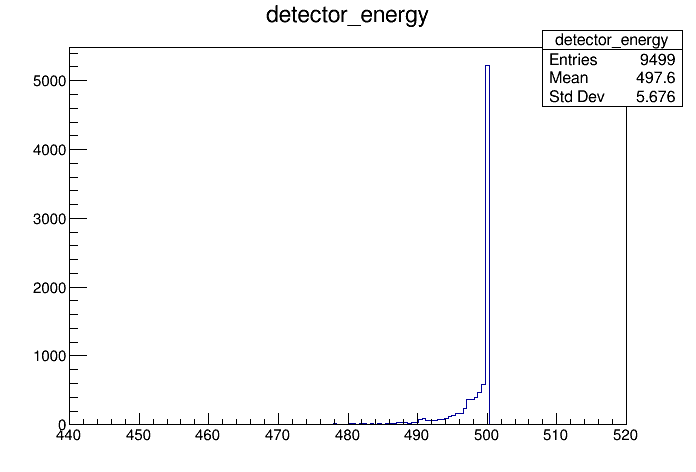

In [24]:
sdetector.energy_hist.Draw()
canvas.Draw()

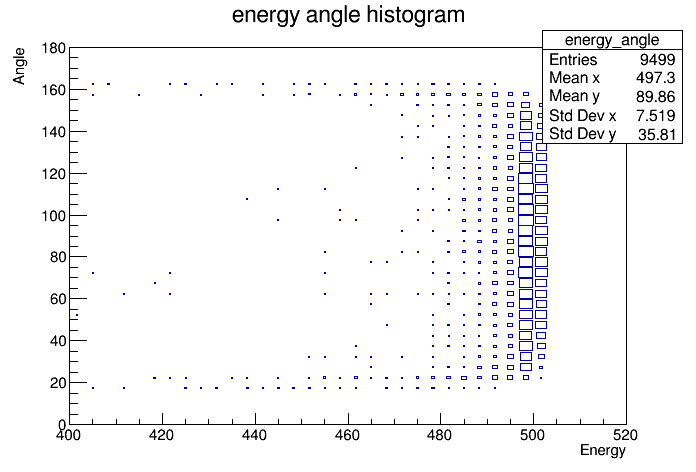

In [25]:
sdetector.energy_angle_hist.Draw("box")
canvas.Draw()

In [26]:
#Theoretical efficiency

#area into which particles fall
S_particles = math.pi*25**2 - 2* math.pi * 25* math.sin(18)
S_detector = math.pi * 25 * 25

efficiency = S_detector/S_particles

print(f"Theoretical efficiency: {efficiency * 100}%")

#Experimental efficiency
print(f"Experimental efficiency: {eff * 100}%")

Theoretical efficiency: 94.33259399631044%
Experimental efficiency: 94.99%
